# Reading optimisation results into dataframes

In [40]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [41]:
# grid search results
with open("../raport/knn_naive.json", "r") as file:
    data_knn = json.load(file)
with open("../raport/logistic_naive.json", "r") as file:
    data_logistic = json.load(file)
with open("../raport/xgboost_naive.json", "r") as file:
    data_Xgboost = json.load(file)

print("liczba ramek danych do KNN:", len(data_knn))
print("liczba ramek danych do logistic regression:", len(data_logistic))
print("liczba ramek danych do Xgboost:", len(data_Xgboost))

liczba ramek danych do KNN: 5
liczba ramek danych do logistic regression: 5
liczba ramek danych do Xgboost: 5


In [42]:
# reading json files into dataframes for each model
# KNN
def load_KNN_dataframe(data):
    records = []
    best_records = []

    # iterate through each dict in json
    for index, item in enumerate(data):
        best_params = item["best_params"]
        best_score = item["best_score"]

        best_record = {
            "df_number": index,
            "algorithm": best_params["algorithm"],
            "leaf_size": best_params["leaf_size"],
            "metric": best_params["metric"],
            "n_neighbors": best_params["n_neighbors"],
            "weights": best_params["weights"],
            "best_score": best_score,
        }
        best_records.append(
            best_record
        )  # dataframe with best KNN parameters for each dataframe

        for result in item["results"]:
            params = result["params"]
            record = {
                "df_number": index,
                "algorithm": params["algorithm"],
                "leaf_size": params["leaf_size"],
                "metric": params["metric"],
                "n_neighbors": params["n_neighbors"],
                "weights": params["weights"],
                "mean_test_score": result["mean_test_score"],
            }
            records.append(
                record
            )  # dataframe with all parameter combinations for each dataframe

    return (pd.DataFrame(best_records), pd.DataFrame(records))

In [43]:
# Logistic regression
def load_log_reg_dataframe(data):
    records = []
    best_records = []

    # iterate through each dict in json
    for index, item in enumerate(data):
        best_params = item["best_params"]
        best_score = item["best_score"]

        # best params for each dataframe
        best_record = {
            "df_number": index,
            "C": best_params["C"],
            "class_weight": best_params["class_weight"],
            "fit_intercept": best_params["fit_intercept"],
            "max_iter": best_params["max_iter"],
            "tol": best_params["tol"],
            "best_score": best_score,
        }
        best_records.append(best_record)

        # all parameter combinations for each dataframe
        for result in item["results"]:
            params = result["params"]
            record = {
                "df_number": index,
                "C": params["C"],
                "class_weight": params["class_weight"],
                "fit_intercept": params["fit_intercept"],
                "max_iter": params["max_iter"],
                "tol": params["tol"],
                "mean_test_score": result["mean_test_score"],
            }
            records.append(record)  #

    return (pd.DataFrame(best_records), pd.DataFrame(records))

In [44]:
# XGboost
def load_xgboost_dataframe(data):
    records = []
    best_records = []

    # iterate through every dict in json
    for index, item in enumerate(data):
        best_params = item["best_params"]
        best_score = item["best_score"]

        # best parameters for each df
        best_record = {
            "df_number": index,
            "eval_metric": best_params["eval_metric"],
            "gamma": best_params["gamma"],
            "learning_rate": best_params["learning_rate"],
            "max_depth": best_params["max_depth"],
            "min_child_weight": best_params["min_child_weight"],
            "n_estimators": best_params["n_estimators"],
            "best_score": best_score,
        }
        best_records.append(best_record)

        # all parameter combinations for each df
        for result in item["results"]:
            params = result["params"]
            record = {
                "df_number": index,
                "eval_metric": params["eval_metric"],
                "gamma": params["gamma"],
                "learning_rate": params["learning_rate"],
                "max_depth": params["max_depth"],
                "min_child_weight": params["min_child_weight"],
                "n_estimators": params["n_estimators"],
                "mean_test_score": result["mean_test_score"],
            }
            records.append(record)
    return (pd.DataFrame(best_records), pd.DataFrame(records))

## Grid Search results dataframes

In [45]:
knn_best_params, knn_all_params = load_KNN_dataframe(data_knn)
log_best_params, log_all_params = load_log_reg_dataframe(data_logistic)
xg_best_params, xg_all_params = load_xgboost_dataframe(data_Xgboost)

xg_all_params

,df_number,eval_metric,gamma,learning_rate,max_depth,min_child_weight,n_estimators,mean_test_score
0,0,logloss,0.0,0.01,10,1,100,1.000000
1,0,logloss,0.0,0.01,10,1,300,1.000000
2,0,logloss,0.0,0.01,10,1,500,1.000000
3,0,logloss,0.0,0.01,10,1,1000,1.000000
4,0,logloss,0.0,0.01,10,2,100,1.000000
...,...,...,...,...,...,...,...,...
6475,4,auc,0.3,0.10,20,5,1000,0.993279
6476,4,auc,0.3,0.10,20,10,100,0.992737
6477,4,auc,0.3,0.10,20,10,300,0.992839
6478,4,auc,0.3,0.10,20,10,500,0.992839


## Deafult param sets using Grid Search results

According to the definition in the paper default parameter set will be the one that gives the highest average score across all dataframes

In [46]:
def find_default_params(dataframe, parameters):
    # making sure that each df was tested on same param sets
    group_sizes = dataframe.groupby(parameters).size()
    has_five_records = (group_sizes == 5).all()
    print("All dataframes were tested on the same param set: ", has_five_records)

    aggregated_df = (
        dataframe.groupby(parameters)
        .agg(average_score=("mean_test_score", "mean"))
        .reset_index()
    )
    max_score_set = aggregated_df.sort_values(by="average_score", ascending=False).iloc[
        0
    ]
    return max_score_set

In [47]:
# XGBoost deafults
xg_exclude_columns = [
    "df_number",
    "mean_test_score",
]  # exclude columns that are not model parameters
xg_params = [col for col in xg_all_params.columns if col not in xg_exclude_columns]
xg_boost_default = find_default_params(xg_all_params, xg_params)
print("XGBoost deault paramset:\n", xg_boost_default, "\n")

# KNN deafults
knn_exclude_columns = ["df_number", "mean_test_score"]
knn_params = [col for col in knn_all_params.columns if col not in knn_exclude_columns]
knn_default = find_default_params(knn_all_params, knn_params)
print("Knn default paramset:\n", knn_default, "\n")

# Logistic regression deaults
log_exclude_columns = ["df_number", "mean_test_score"]
log_params = [col for col in log_all_params.columns if col not in log_exclude_columns]
log_default = find_default_params(log_all_params, log_params)
print("Log regression default paramset:\n", log_default, "\n")

All dataframes were tested on the same param set:  True
XGBoost deault paramset:
 eval_metric          logloss
gamma                   0.15
learning_rate           0.01
max_depth                 10
min_child_weight          10
n_estimators             100
average_score       0.758767
Name: 1020, dtype: object 

All dataframes were tested on the same param set:  True
Knn default paramset:
 algorithm        ball_tree
leaf_size               50
metric           manhattan
n_neighbors             50
weights           distance
average_score       0.7307
Name: 494, dtype: object 

All dataframes were tested on the same param set:  True
Log regression default paramset:
 C                1291.549665
class_weight        balanced
fit_intercept           True
max_iter               50000
tol                    0.001
average_score       0.744689
Name: 71, dtype: object 



## Bayes search results

In [48]:
with open("../raport/knn_bayes.json", "r") as file:
    data_knn_bayes = json.load(file)
with open("../raport/logistic_bayes.json", "r") as file:
    data_logistic_bayes = json.load(file)
with open("../raport/xgboost_bayes.json", "r") as file:
    data_Xgboost_bayes = json.load(file)

# check
print("liczba ramek danych do KNN:", len(data_knn_bayes))
print("liczba ramek danych do logistic regression:", len(data_logistic_bayes))
print("liczba ramek danych do Xgboost:", len(data_Xgboost_bayes))

liczba ramek danych do KNN: 5
liczba ramek danych do logistic regression: 5
liczba ramek danych do Xgboost: 5


In [49]:
knn_best_params_bayes, knn_all_params_bayes = load_KNN_dataframe(data_knn_bayes)
log_best_params_bayes, log_all_params_bayes = load_log_reg_dataframe(
    data_logistic_bayes
)
xg_best_params_bayes, xg_all_params_bayes = load_xgboost_dataframe(data_Xgboost_bayes)

log_all_params_bayes

,df_number,C,class_weight,fit_intercept,max_iter,tol,mean_test_score
0,0,0.359381,balanced,False,50000,0.00010,0.963879
1,0,1291.549665,balanced,True,50000,0.00100,0.999674
2,0,0.359381,balanced,True,50000,0.00010,0.982074
3,0,1291.549665,None,False,50000,0.00100,0.987221
4,0,166.810054,None,False,50000,0.00001,0.999179
...,...,...,...,...,...,...,...
495,4,0.046416,None,True,50000,0.00010,0.929628
496,4,21.544347,None,False,50000,0.00001,0.908638
497,4,0.005995,None,True,50000,0.00001,0.923881
498,4,10000.000000,balanced,True,50000,0.00100,0.932636


# Stability analysis

Lets check max Auc depending on the number of iterations for Grid Search and for Bayes Search to see the differences

In [50]:
def plot_stability(model_df, thresholds, title):

    colors = ["#07b1bf", "#4796e9", "#9d47e9", "#46edf0", "#4905d3"]
    labels = ["Ramka 1", "Ramka 2", "Ramka 3", "Ramka 4", "Ramka 5"]

    # AUC scaling for each dataframe (for the plots to be on one figure)
    max_score = model_df["mean_test_score"].max()
    model_df["scaled_score"] = model_df["mean_test_score"] / max_score

    # plot every dataframe results
    plt.figure(figsize=(20, 10))
    for df_number in range(5):

        df = model_df[
            model_df["df_number"] == df_number
        ].reset_index()  # select rows for each df
        max_scores = {
            threshold: (
                round(df["mean_test_score"][:threshold].max(), 5)
                if threshold > 0
                else round(df["mean_test_score"].iloc[0], 5)
            )
            for threshold in thresholds
        }  # max score so far for each threshold (when 0 then just the score in 1 iteration)

        x_values = list(max_scores.keys())
        y_values = list(max_scores.values())

        plt.plot(
            x_values,
            y_values,
            linestyle="-",
            linewidth=2,
            color=colors[df_number],
            label=labels[df_number],
        )

    plt.title(title, fontsize=20, pad=30)
    plt.xlabel("Liczba iteracji", fontsize=15)
    plt.ylabel("Maksymalne AUC", fontsize=15)
    plt.xticks(x_values, rotation=60)  # Ustawianie znaczników na osi X
    plt.xlim(left=0)  # zaczynanie od 0
    plt.gca().spines["top"].set_visible(False)  # usuwanie obramowania z gory i prawej
    plt.gca().spines["right"].set_visible(False)
    plt.legend(loc="upper right", bbox_to_anchor=(1.05, 1))
    plt.grid(alpha=0.4)
    plt.show()

### Grid Search stability

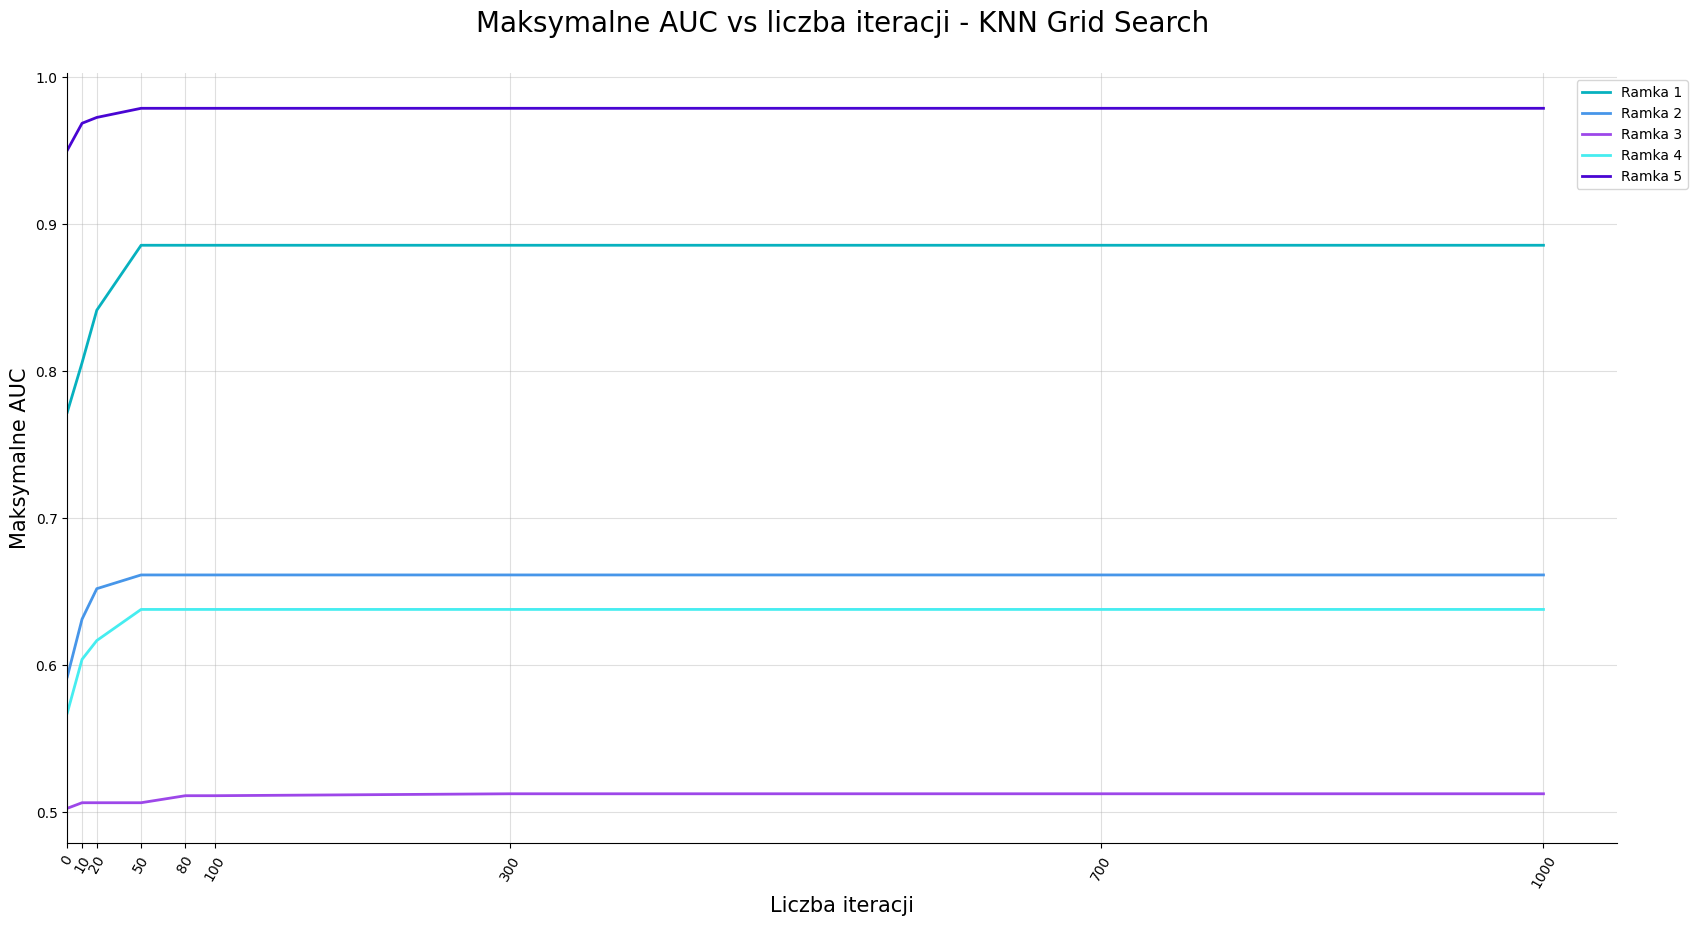

In [51]:
plot_stability(
    knn_all_params,
    [0, 10, 20, 50, 80, 100, 300, 700, 1000],
    "Maksymalne AUC vs liczba iteracji - KNN Grid Search",
)

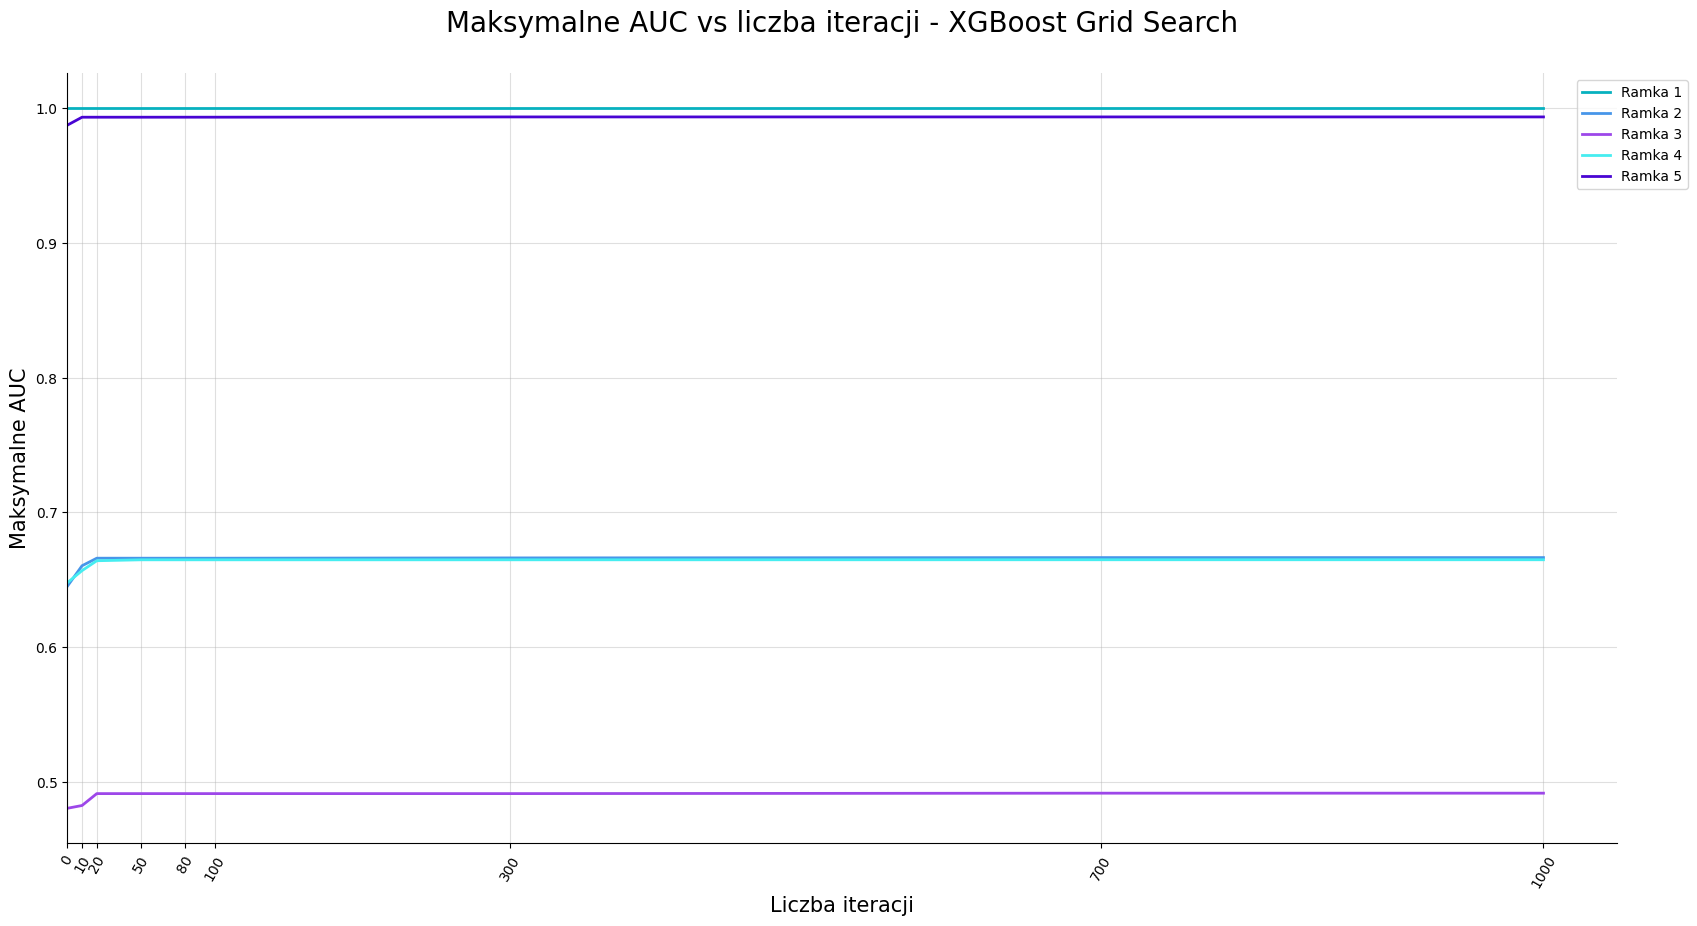

In [52]:
plot_stability(
    xg_all_params,
    [0, 10, 20, 50, 80, 100, 300, 700, 1000],
    "Maksymalne AUC vs liczba iteracji - XGBoost Grid Search",
)

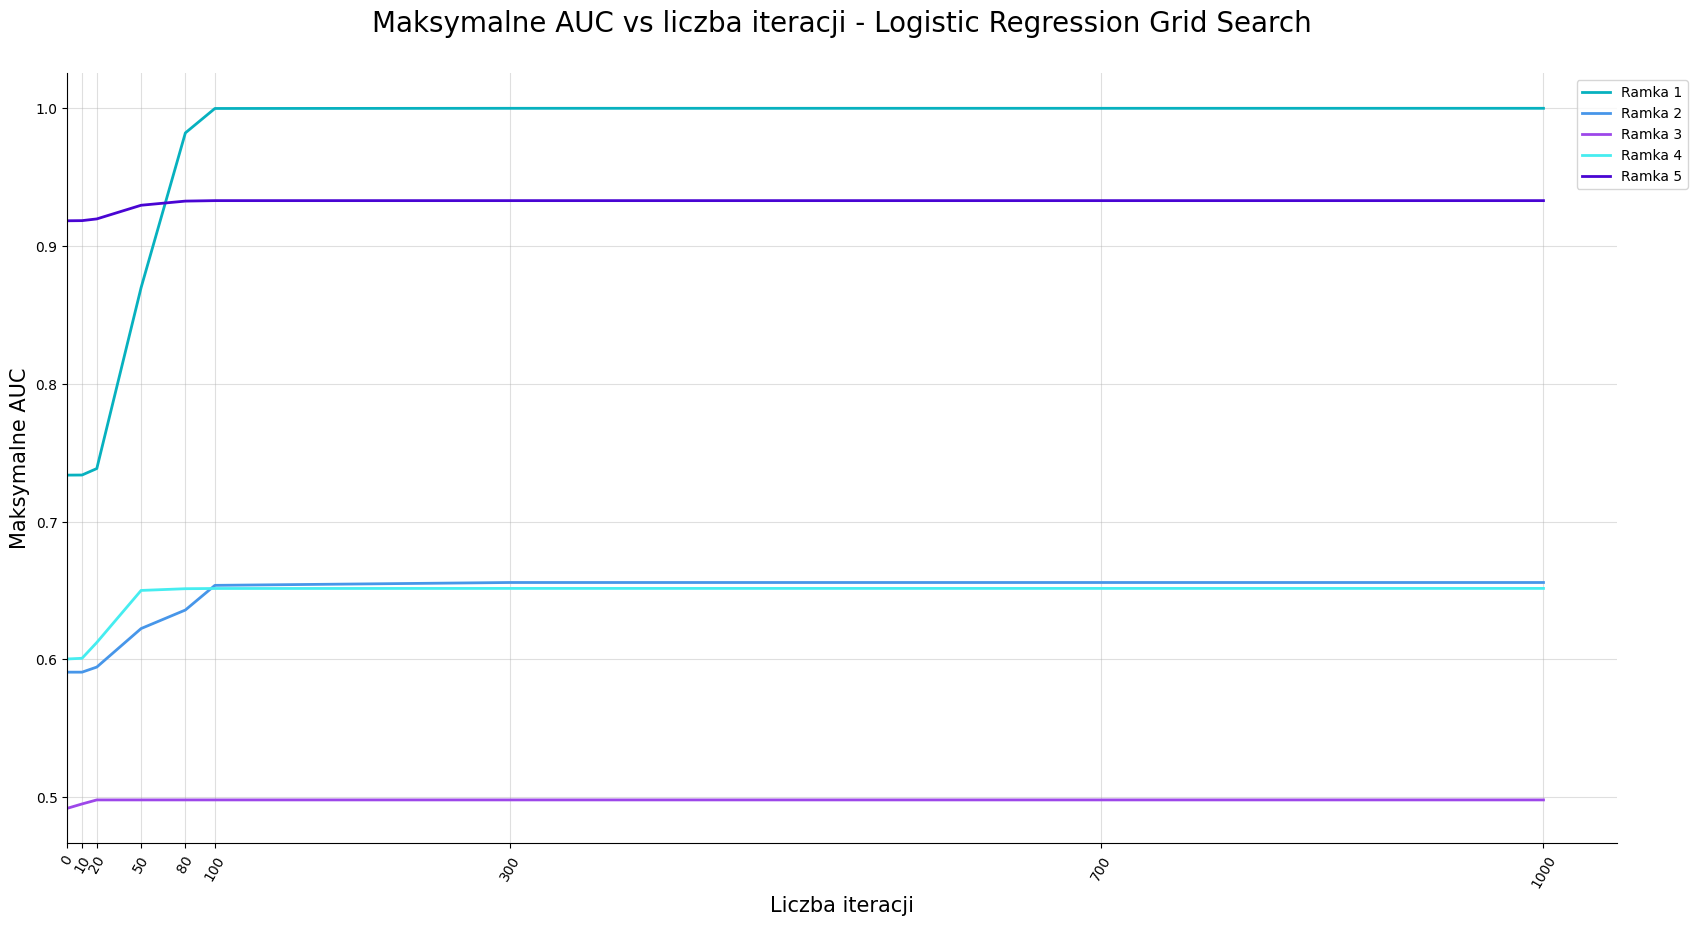

In [53]:
plot_stability(
    log_all_params,
    [0, 10, 20, 50, 80, 100, 300, 700, 1000],
    "Maksymalne AUC vs liczba iteracji - Logistic Regression Grid Search",
)

### Bayes Search stability

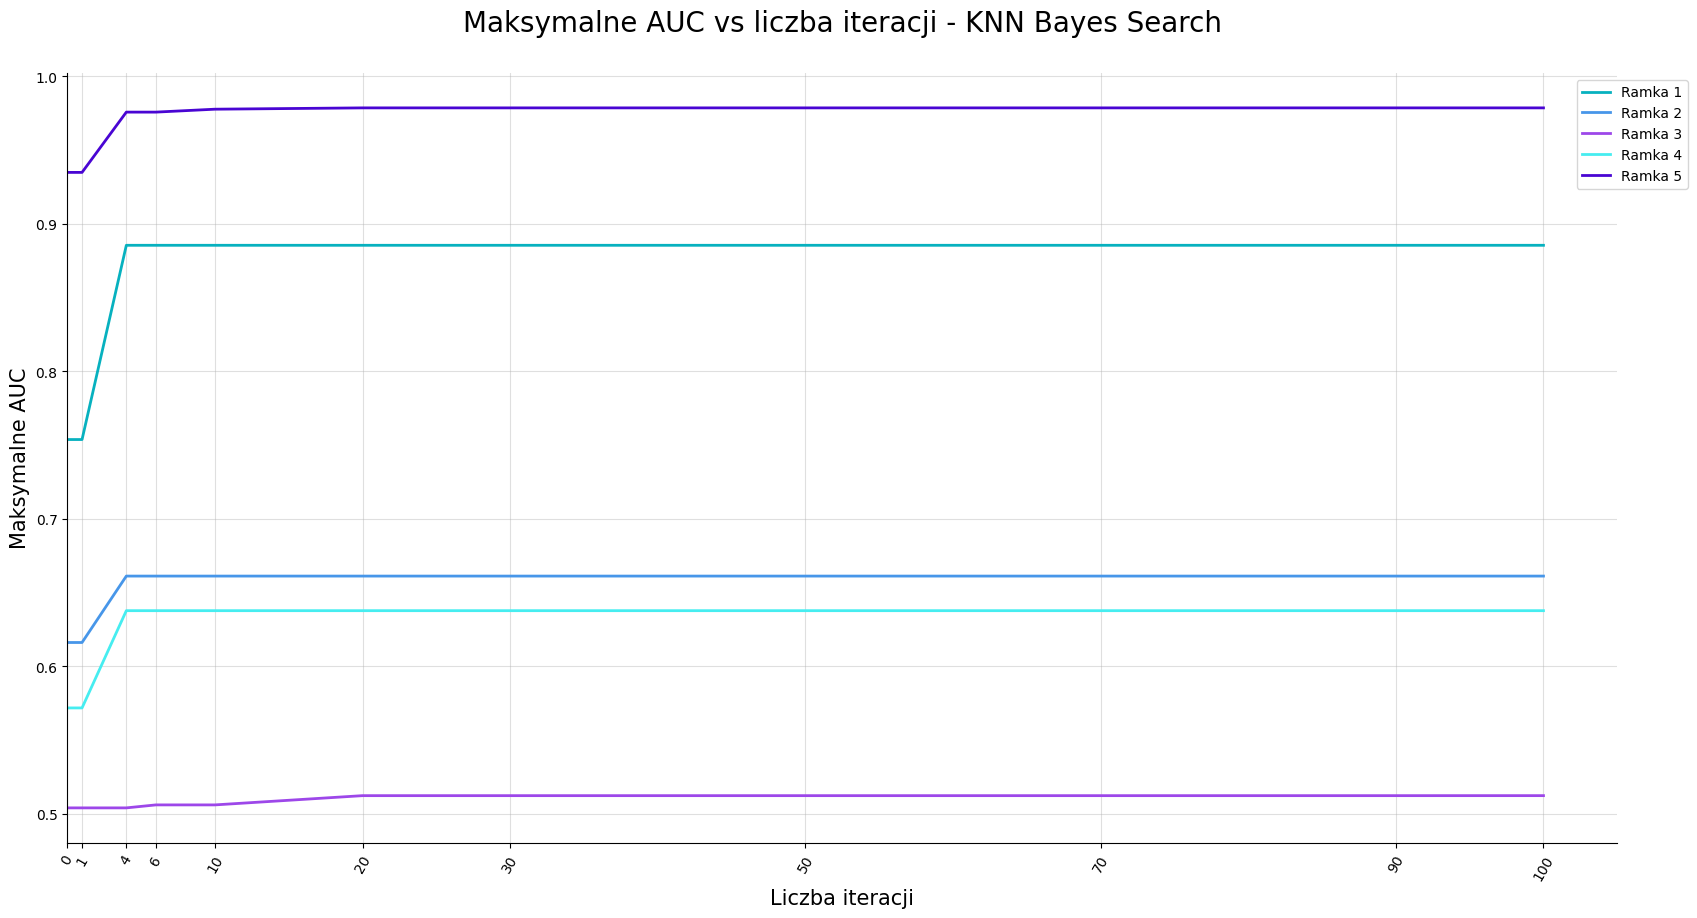

In [54]:
plot_stability(
    knn_all_params_bayes,
    [0, 1, 4, 6, 10, 20, 30, 50, 70, 90, 100],
    "Maksymalne AUC vs liczba iteracji - KNN Bayes Search",
)

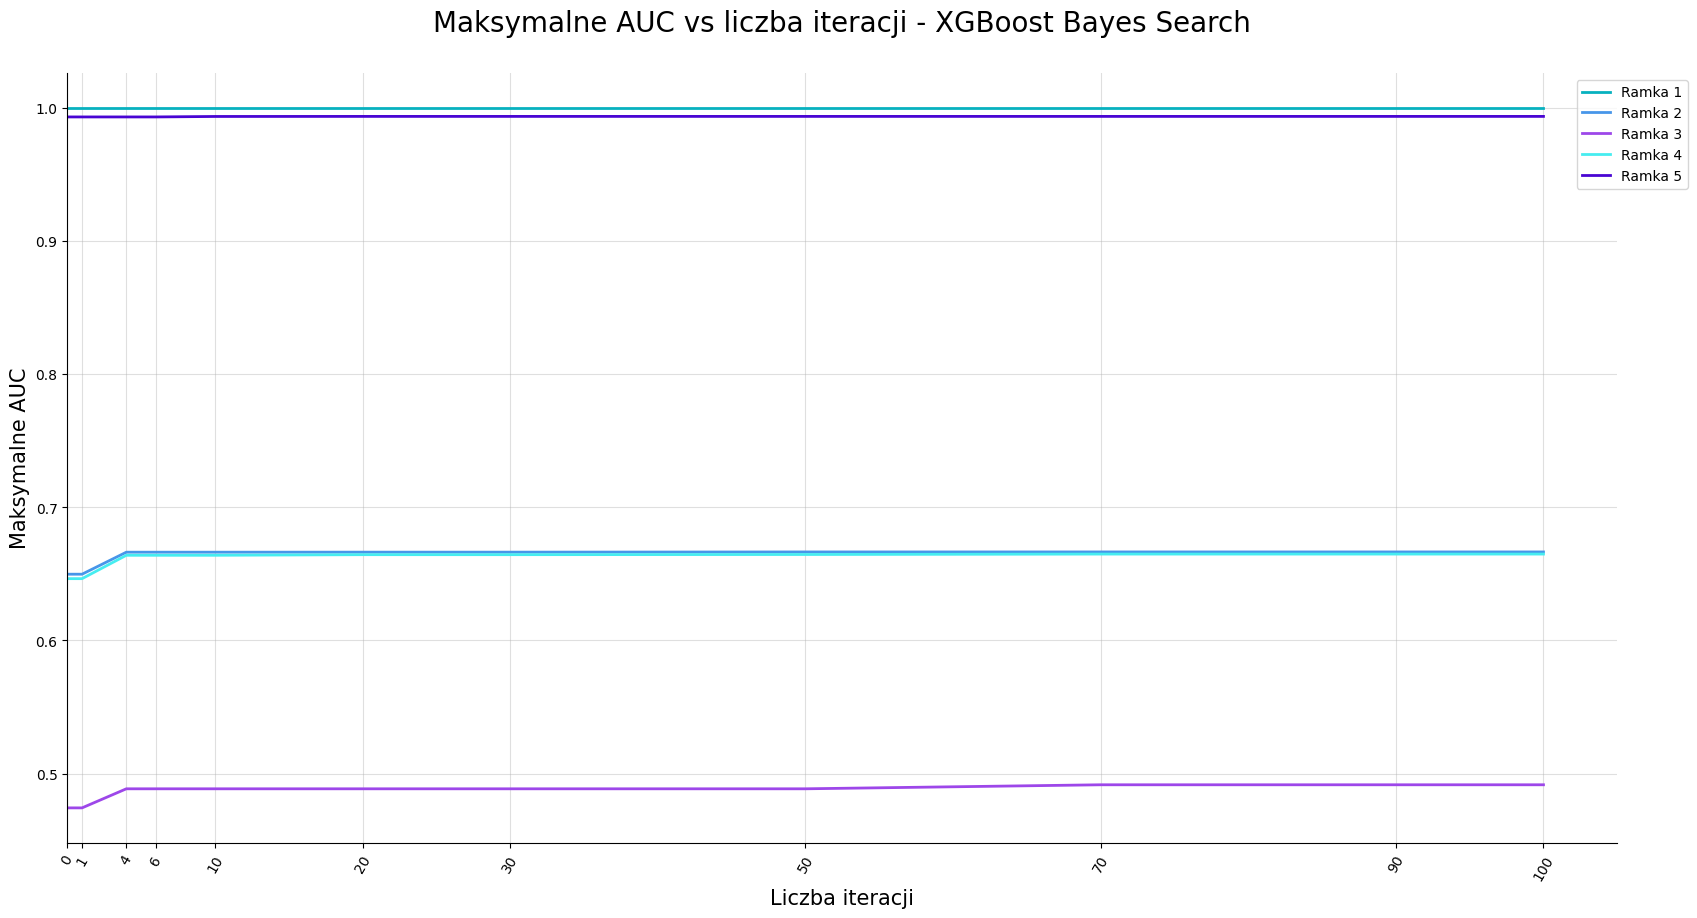

In [55]:
plot_stability(
    xg_all_params_bayes,
    [0, 1, 4, 6, 10, 20, 30, 50, 70, 90, 100],
    "Maksymalne AUC vs liczba iteracji - XGBoost Bayes Search",
)

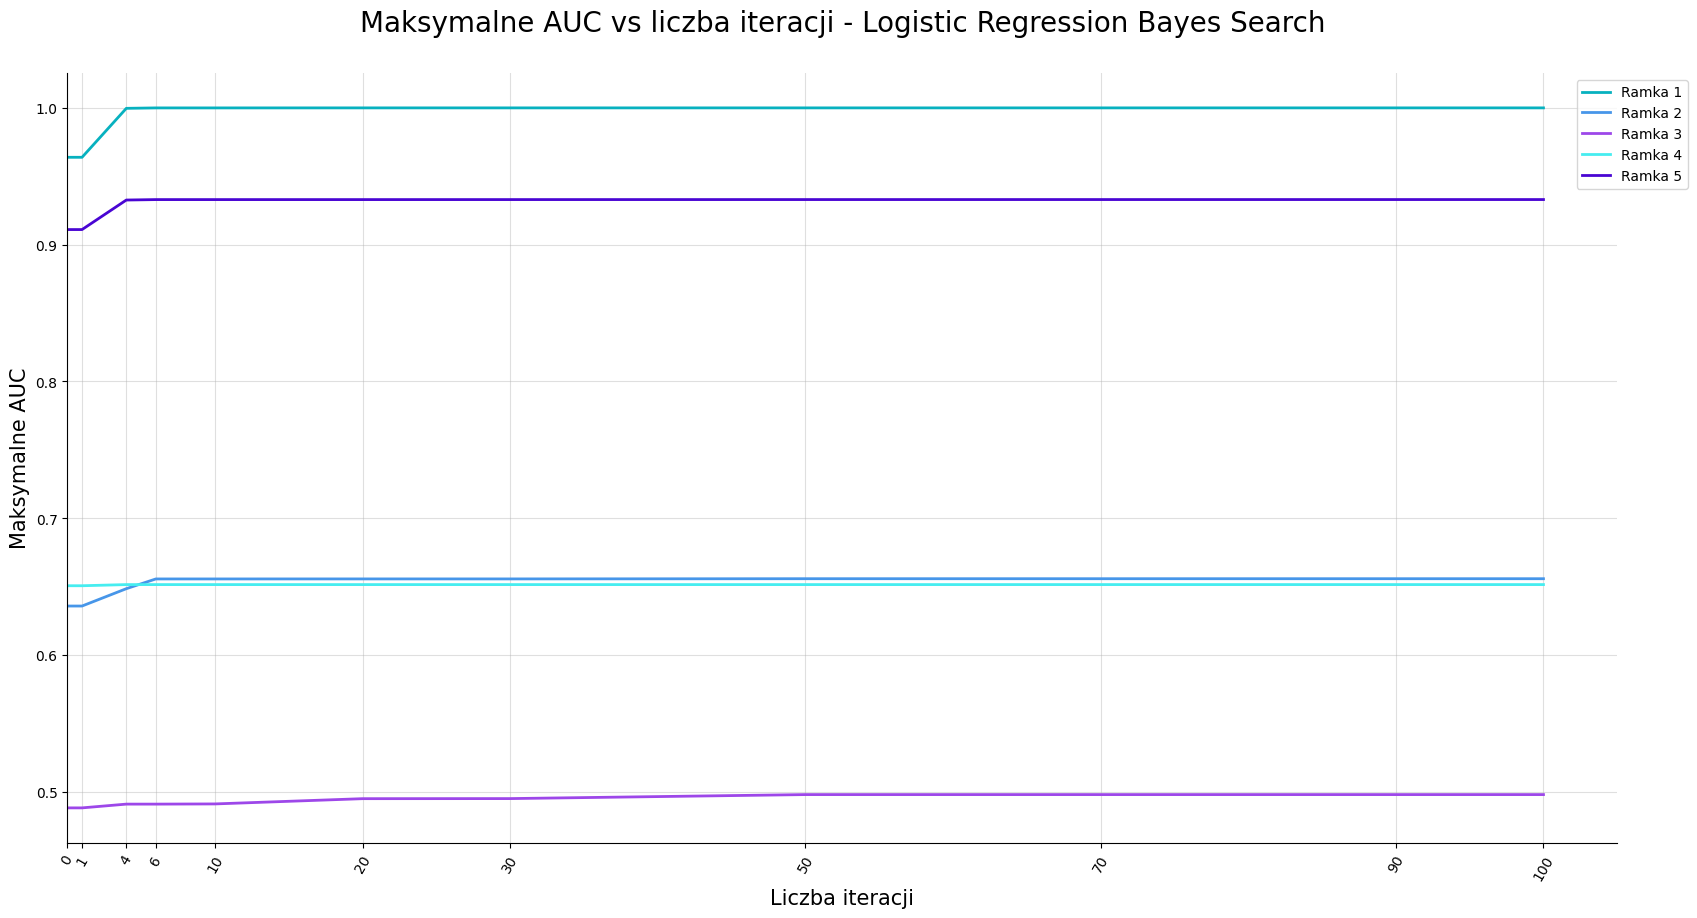

In [56]:
plot_stability(
    log_all_params_bayes,
    [0, 1, 4, 6, 10, 20, 30, 50, 70, 90, 100],
    "Maksymalne AUC vs liczba iteracji - Logistic Regression Bayes Search",
)

## Iteration vs score 

Lets check how score in each iteration differs with Grid Search i Bayes search on 2 example datasets

Text(0, 0.5, 'AUC')

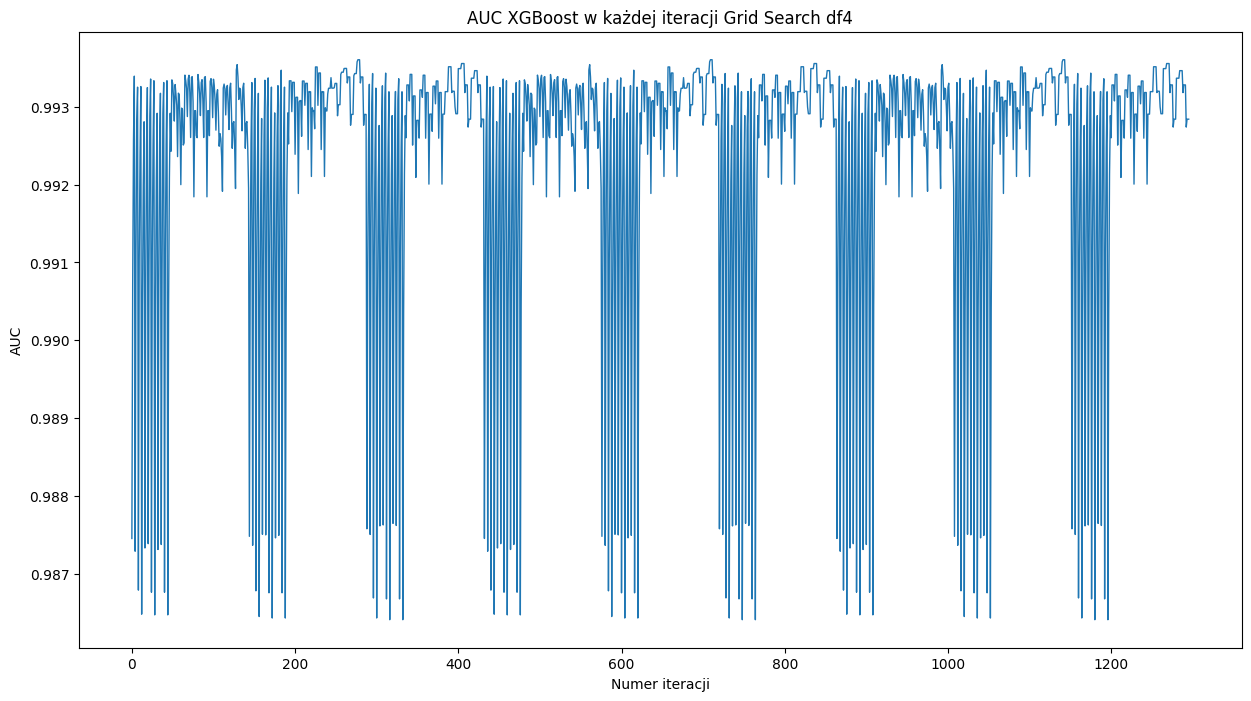

In [57]:
df = xg_all_params[xg_all_params["df_number"] == 4].reset_index()
iteration_numbers = df.index  # To będą numery iteracji (wierszy)
scores = df["mean_test_score"]  # Wartości AUC dla tych iteracji
plt.figure(figsize=(15, 8))
plt.plot(iteration_numbers, scores, linestyle="-", linewidth=1)
plt.title("AUC XGBoost w każdej iteracji Grid Search df4")
plt.xlabel("Numer iteracji")
plt.ylabel("AUC")

Text(0, 0.5, 'AUC')

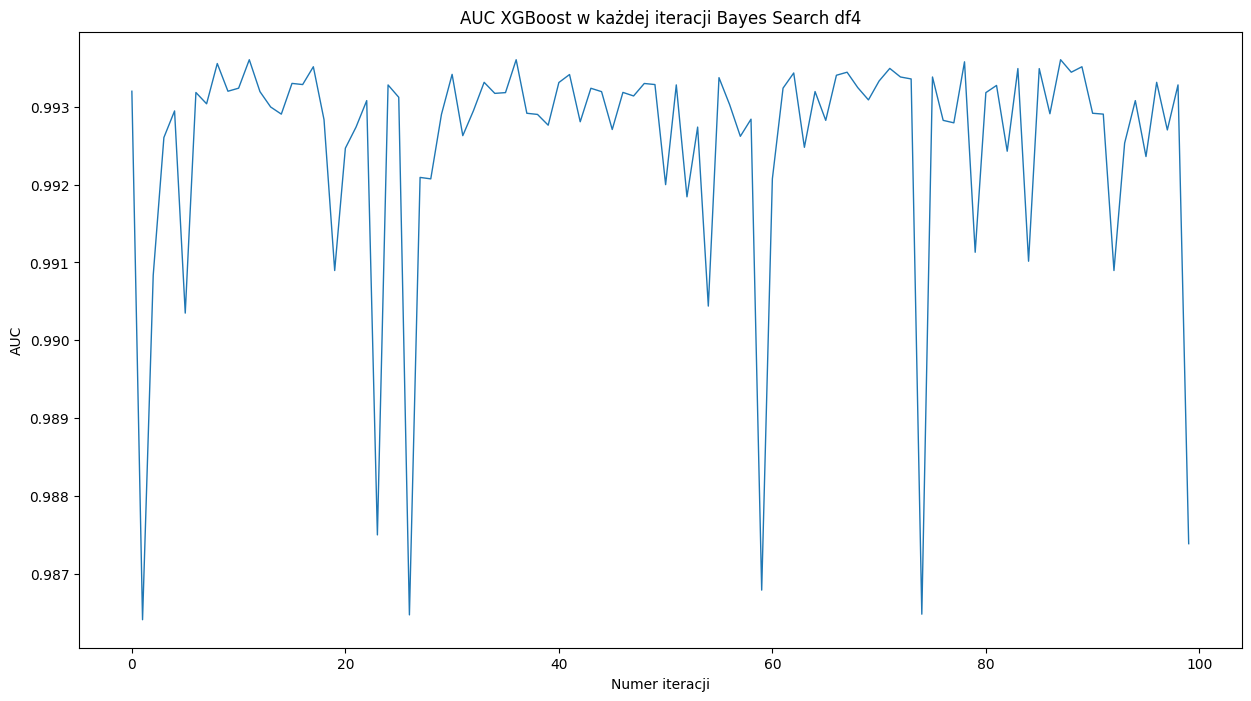

In [58]:
df = xg_all_params_bayes[xg_all_params_bayes["df_number"] == 4].reset_index()
iteration_numbers = df.index  # To będą numery iteracji (wierszy)
scores = df["mean_test_score"]  # Wartości AUC dla tych iteracji
plt.figure(figsize=(15, 8))
plt.plot(iteration_numbers, scores, linestyle="-", linewidth=1)
plt.title("AUC XGBoost w każdej iteracji Bayes Search df4")
plt.xlabel("Numer iteracji")
plt.ylabel("AUC")

Text(0, 0.5, 'AUC')

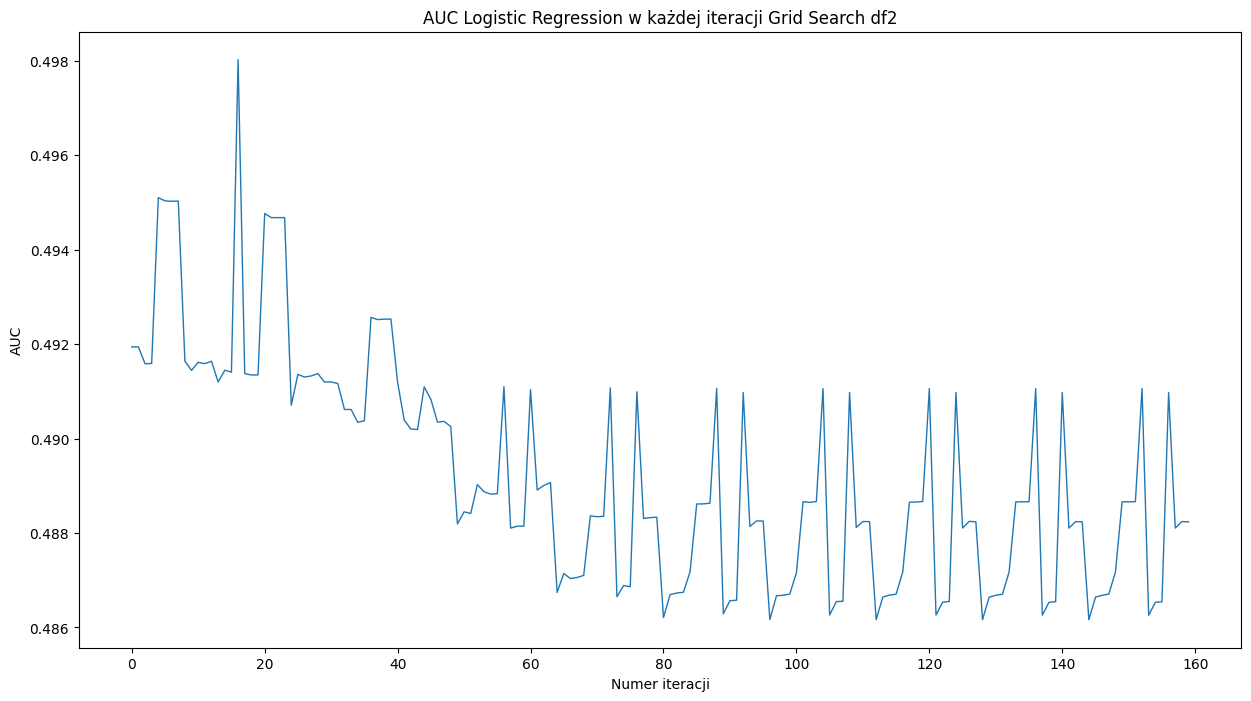

In [59]:
df = log_all_params[log_all_params["df_number"] == 2].reset_index()
iteration_numbers = df.index  # To będą numery iteracji (wierszy)
scores = df["mean_test_score"]  # Wartości AUC dla tych iteracji
plt.figure(figsize=(15, 8))
plt.plot(iteration_numbers, scores, linestyle="-", linewidth=1)
plt.title("AUC Logistic Regression w każdej iteracji Grid Search df2")
plt.xlabel("Numer iteracji")
plt.ylabel("AUC")

Text(0, 0.5, 'AUC')

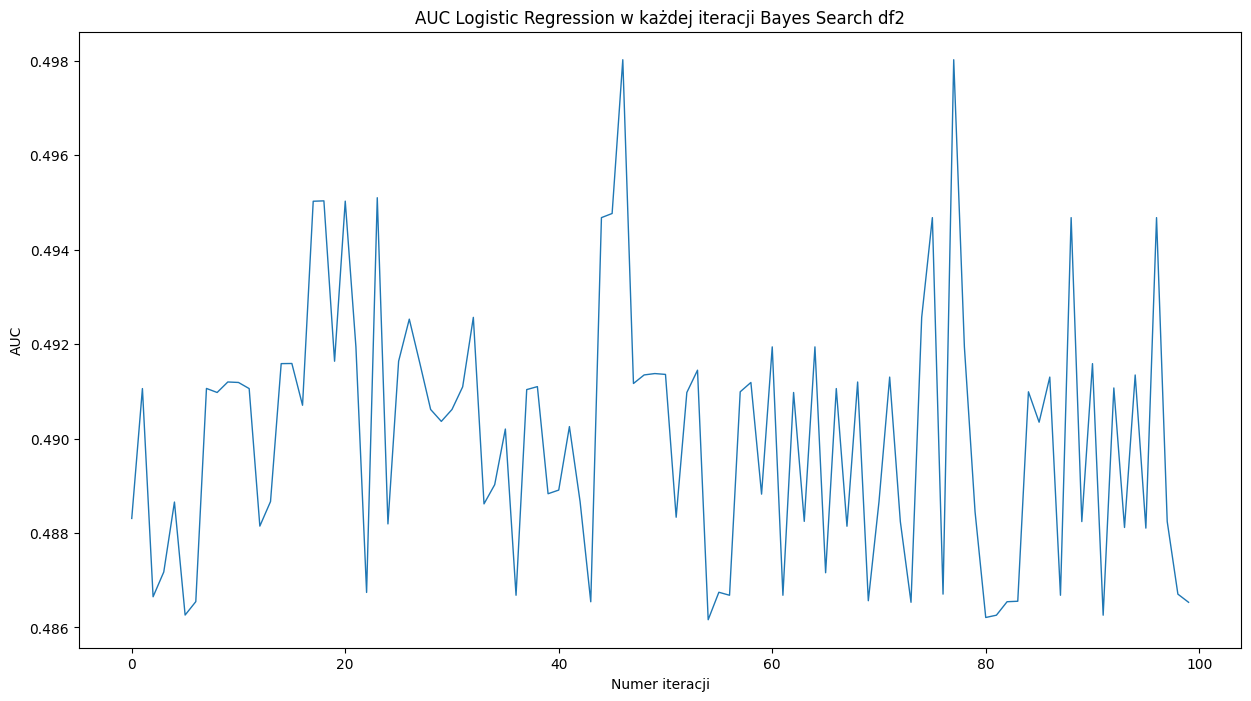

In [60]:
df = log_all_params_bayes[log_all_params_bayes["df_number"] == 2].reset_index()
iteration_numbers = df.index  # To będą numery iteracji (wierszy)
scores = df["mean_test_score"]  # Wartości AUC dla tych iteracji
plt.figure(figsize=(15, 8))
plt.plot(iteration_numbers, scores, linestyle="-", linewidth=1)
plt.title("AUC Logistic Regression w każdej iteracji Bayes Search df2")
plt.xlabel("Numer iteracji")
plt.ylabel("AUC")

## Checking for suspicious behaviour in XGBoost for df1, df5

In [61]:
xg_all_params.loc[
    xg_all_params["df_number"] == 0, "mean_test_score"
].nunique()  # coś nie tak

1

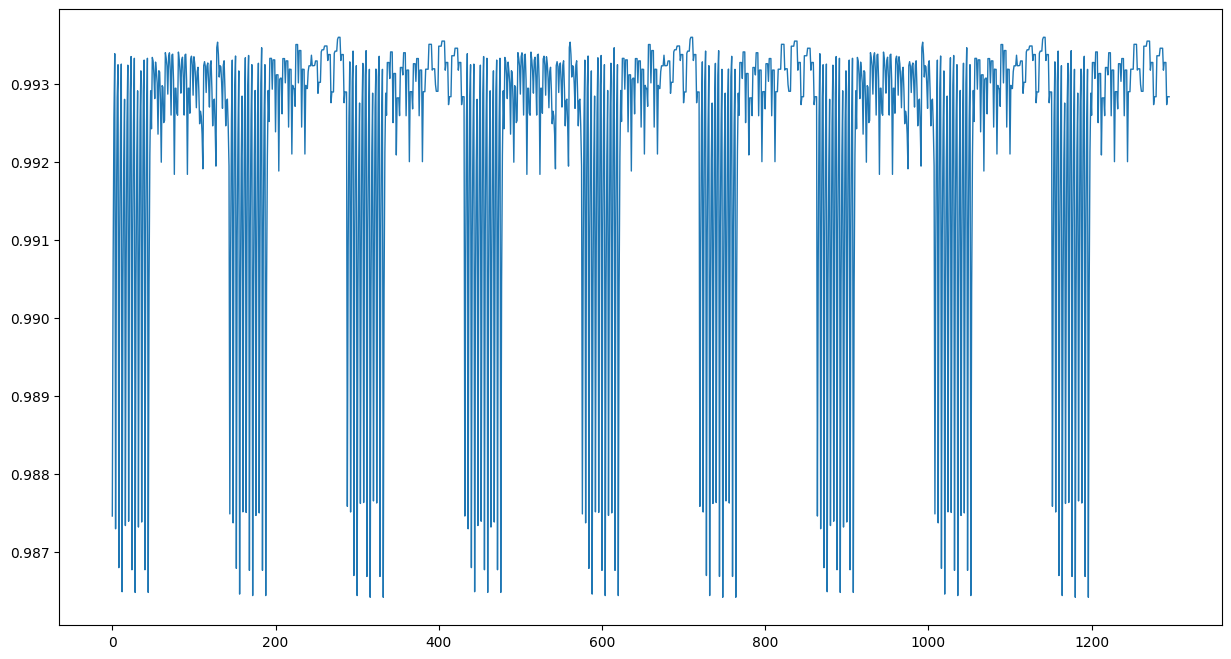

In [62]:
df = xg_all_params[xg_all_params["df_number"] == 4].reset_index()
iteration_numbers = df.index  # To będą numery iteracji (wierszy)
scores = df["mean_test_score"]  # Wartości AUC dla tych iteracji
plt.figure(figsize=(15, 8))
plt.plot(iteration_numbers, scores, linestyle="-", linewidth=1)

Widzimy, że różne iteracje dają różne score, więc po prostu szybko znalazł max.

# Tunability

As defined in the article algorithms tunability is a difference between best score and score on default parameters (somehow aggregated for all used dataframes). We will plot those differences for both grid search and bayes search to see if the results are similar or not.

In [63]:
# function to return row for each df number that has default parameters
def return_rows_with_default_params(dataframe, default_params):
    mask = (dataframe[list(default_params.index)] == default_params.values).all(axis=1)
    matching_rows = dataframe[mask]
    return matching_rows

In [64]:
return_rows_with_default_params(
    knn_all_params, knn_default.drop("average_score")
)  # example how this dataframe looks for KNN model

,df_number,algorithm,leaf_size,metric,n_neighbors,weights,mean_test_score,scaled_score
479,0,ball_tree,50,manhattan,50,distance,0.885430,0.904824
1503,1,ball_tree,50,manhattan,50,distance,0.661207,0.675690
2527,2,ball_tree,50,manhattan,50,distance,0.493391,0.504198
3551,3,ball_tree,50,manhattan,50,distance,0.637774,0.651744
4575,4,ball_tree,50,manhattan,50,distance,0.975696,0.997068


## Calculating differences

In [65]:
# function that takes a dataframe with results for all 6 dfs and megres it with results on default params on df_number + adds model column
def prepare_score_differences(df, default_df, source_name, score_col, def_score_col):
    merged_df = pd.merge(df, default_df, on="df_number", how="left")
    merged_df["score_difference"] = merged_df[score_col] - merged_df[def_score_col]
    merged_df["source"] = source_name  # Dodajemy kolumnę identyfikującą ramkę danych
    return merged_df[["score_difference", "source"]]

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot differences for each df and each model on one boxplot
# Powinniśmy podawać ramki w kolejnośći KNN, XG, Regresja !
def plot_boxplot(dataframes, score_col, def_score_col, title, points=False):
    df1_prepared = prepare_score_differences(
        dataframes[0],
        return_rows_with_default_params(
            knn_all_params, knn_default.drop("average_score")
        ).reset_index(),
        "KNN",
        score_col,
        def_score_col,
    )
    df2_prepared = prepare_score_differences(
        dataframes[1],
        return_rows_with_default_params(
            xg_all_params, xg_boost_default.drop("average_score")
        ).reset_index(),
        "XGBoost",
        score_col,
        def_score_col,
    )
    df3_prepared = prepare_score_differences(
        dataframes[2],
        return_rows_with_default_params(
            log_all_params, log_default.drop("average_score")
        ).reset_index(),
        "Logistic Regression",
        score_col,
        def_score_col,
    )

    # Dataframes for all models to one big df
    combined_df = pd.concat(
        [df1_prepared, df2_prepared, df3_prepared], ignore_index=True
    )
    
    # 3 boxplots on one figure with enhanced aesthetics
    plt.figure(figsize=(12, 8))
    
    # Using Seaborn's color palette for the boxplot
    sns.set_palette("Blues")
    sns.boxplot(x="source", y="score_difference", data=combined_df, linewidth=1.5, boxprops=dict(facecolor='#a7c7e7'))
    
    # Add points if required
    if points:
        sns.stripplot(
            x="source",
            y="score_difference",
            data=combined_df,
            color="#1611b4",  # Darker color for the points
            alpha=0.7,
            jitter=True,
            size=7,  # Increase point size
            dodge=True,  # Separate points for each group
        )
    
    # Enhance title and labels for better readability
    plt.title(title, fontsize=18, fontweight='bold', color="#333333")
    plt.xlabel("Model", fontsize=14, fontweight='bold', color="#333333")
    plt.ylabel("Tunability", fontsize=14, fontweight='bold', color="#333333")
    
    # Customize x and y axis ticks
    plt.xticks(fontsize=12, rotation=0, color="#333333")
    plt.yticks(fontsize=12, color="#333333")
    
    # Add gridlines for better readability
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

## Tunability with grid search

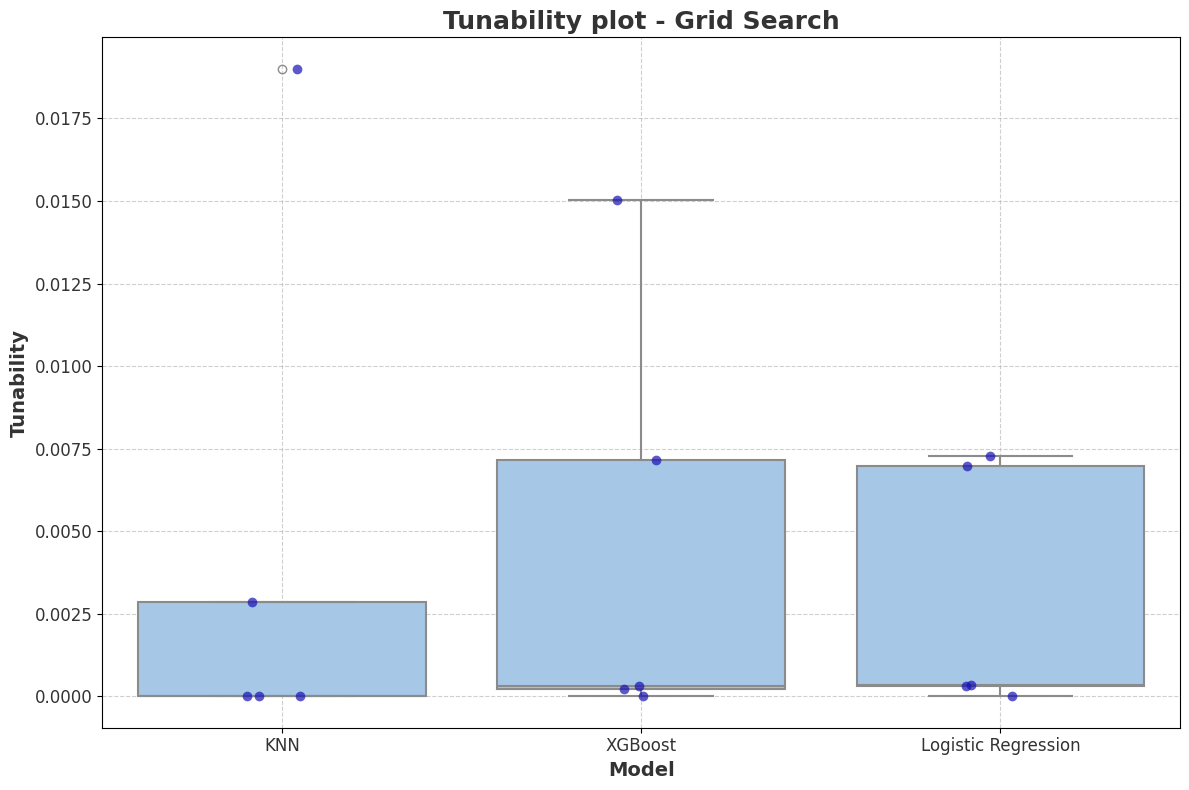

In [67]:
plot_boxplot(
    [knn_best_params, xg_best_params, log_best_params],
    "best_score",
    "mean_test_score",
    "Tunability plot - Grid Search",
    points=True,
)

Let's also plot differnces between all iteration performances and performance on default params

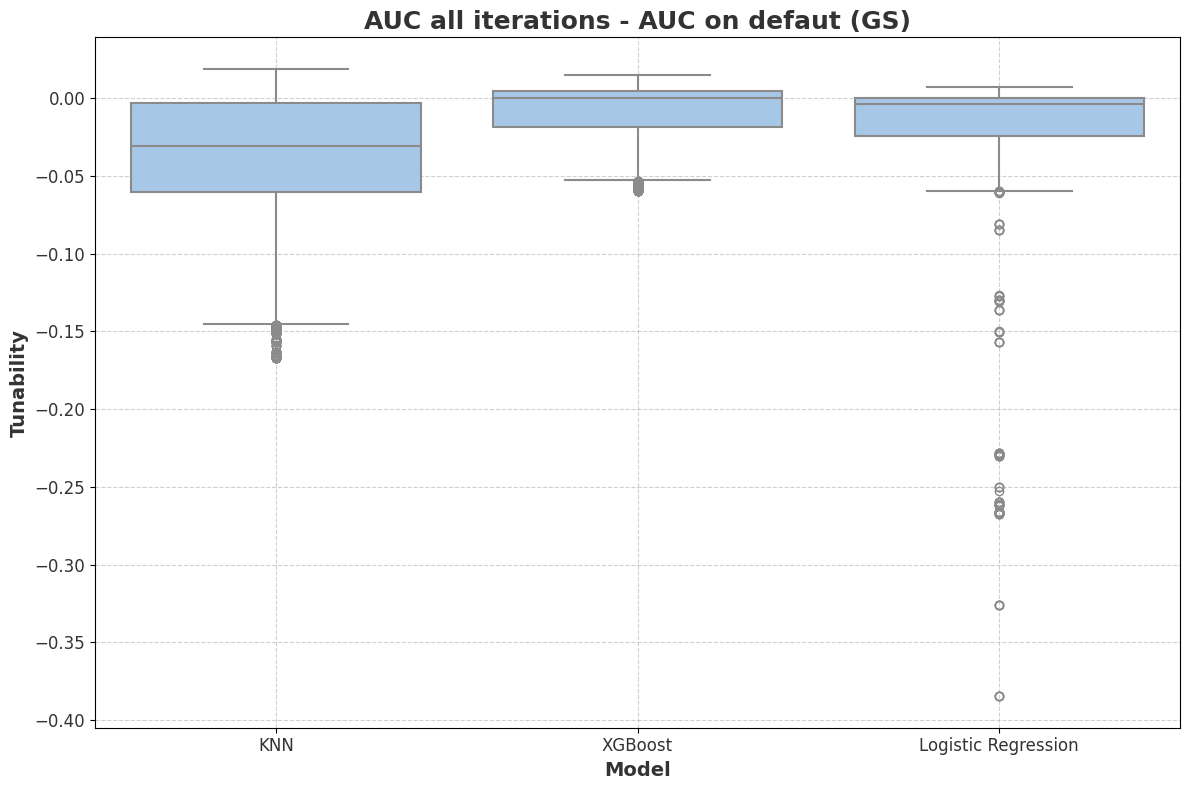

In [68]:
plot_boxplot(
    [knn_all_params, xg_all_params, log_all_params],
    "mean_test_score_x",
    "mean_test_score_y",
    "AUC all iterations - AUC on defaut (GS)",
)

## Tunability Bayes Search

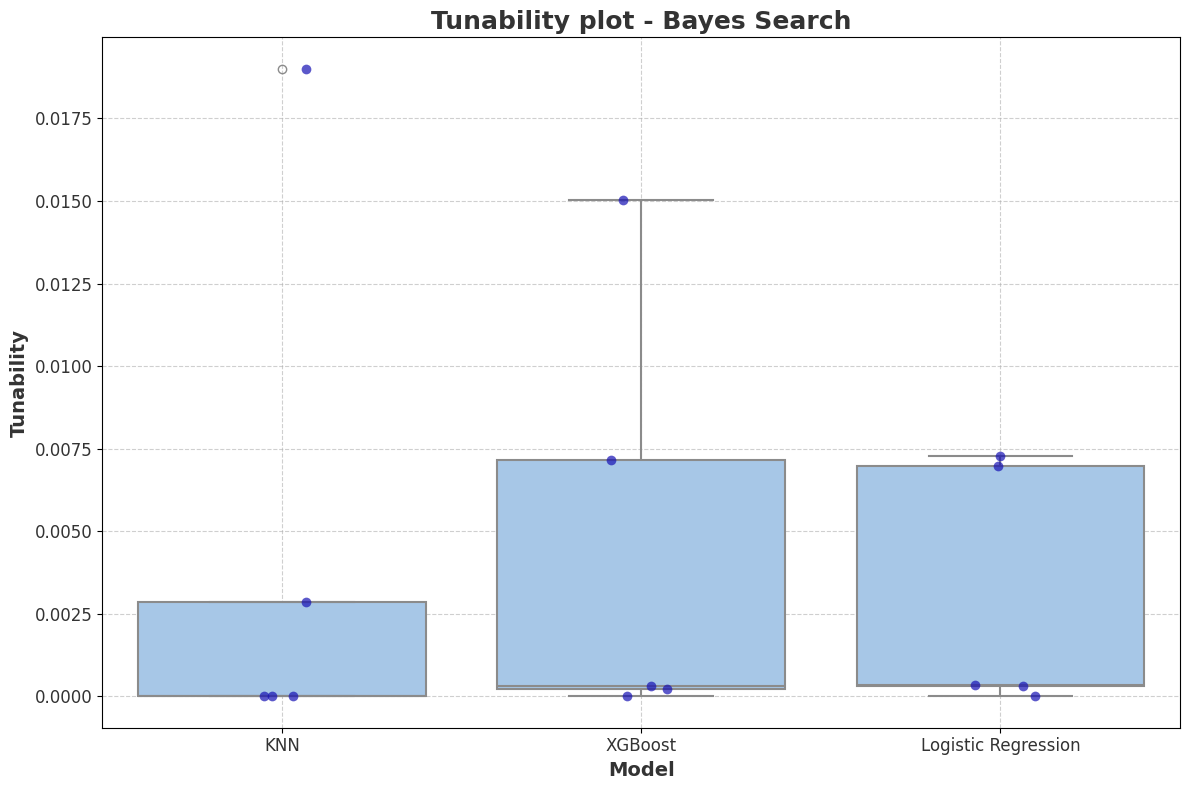

In [69]:
plot_boxplot(
    [knn_best_params_bayes, xg_best_params_bayes, log_best_params_bayes],
    "best_score",
    "mean_test_score",
    "Tunability plot - Bayes Search",
    True,
)

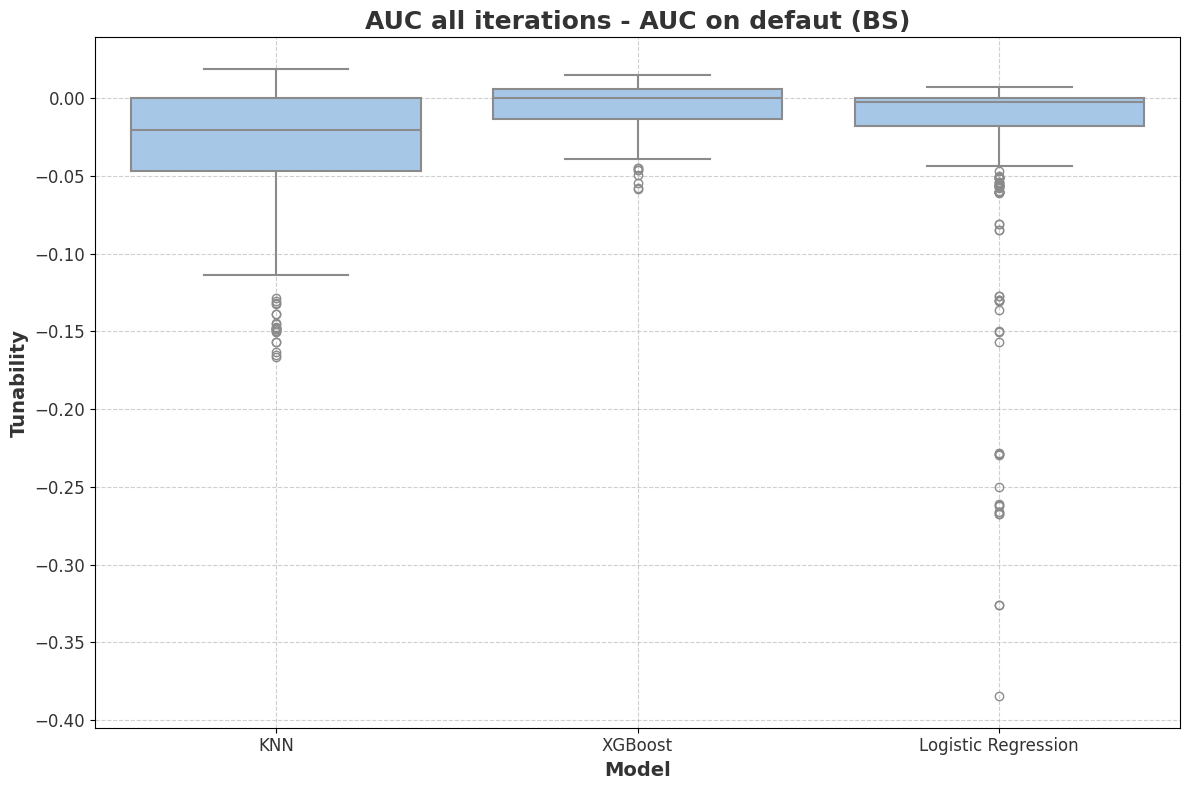

In [70]:
plot_boxplot(
    [knn_all_params_bayes, xg_all_params_bayes, log_all_params_bayes],
    "mean_test_score_x",
    "mean_test_score_y",
    "AUC all iterations - AUC on defaut (BS)",
)

# Times

In [71]:
import pandas as pd

data = {
    'Model': ['LR', 'LR', 'LR', 'LR', 'LR',
              'LR', 'LR', 'LR', 'LR', 'LR',
              'XGBoost', 'XGBoost', 'XGBoost', 'XGBoost', 'XGBoost',
              'XGBoost', 'XGBoost', 'XGBoost', 'XGBoost', 'XGBoost',
              'KNN', 'KNN', 'KNN', 'KNN', 'KNN',
              'KNN', 'KNN', 'KNN', 'KNN', 'KNN'],
    'Search Method': ['Grid Search', 'Grid Search', 'Grid Search', 'Grid Search', 'Grid Search',
                      'Bayes Search', 'Bayes Search', 'Bayes Search', 'Bayes Search', 'Bayes Search',
                      'Grid Search', 'Grid Search', 'Grid Search', 'Grid Search', 'Grid Search',
                      'Bayes Search', 'Bayes Search', 'Bayes Search', 'Bayes Search', 'Bayes Search',
                      'Grid Search', 'Grid Search', 'Grid Search', 'Grid Search', 'Grid Search',
                      'Bayes Search', 'Bayes Search', 'Bayes Search', 'Bayes Search', 'Bayes Search',],
    'Dataset': ['1', '2', '3', '4', '5',
                  '1', '2', '3', '4', '5',
                  '1', '2', '3', '4', '5',
                  '1', '2', '3', '4', '5',
                  '1', '2', '3', '4', '5',
                  '1', '2', '3', '4', '5'],
    'Iterations': [
        160, 160, 160, 160, 160,
        100, 100, 100, 100, 100,
        1296, 1296, 1296, 1296, 1296,
        100, 100, 100, 100, 100,
        1024, 1024, 1024, 1024, 1024,
        100, 100, 100, 100, 100,
    ],
    'Time': [
        3.2025249004364014, 1.5257940292358398, 0.8608238697052002, 9.514772415161133, 1.4122891426086426, # Logistic Regression Grid Search
        210.93536591529846, 233.24227213859558, 206.8353259563446, 233.01116919517517, 208.49409103393555, # Logistic Regression Bayes Search
        76.8900637626648, 584.9128911495209, 472.3676028251648, 1929.6407828330994, 301.16699504852295, # XGBoost Grid Search
        152.68452095985413, 258.10764026641846, 269.5133328437805, 395.64903593063354, 242.16162610054016, # XGBoost Bayes Search
        119.65875697135925, 175.20594382286072, 66.70364999771118, 480.13922572135925, 203.23181009292603, # KNN Grid Search
        207.469340801239, 240.05590415000916, 232.41501903533936, 274.81183886528015, 228.414208650589  # KNN Bayes Search
    ]
}

df = pd.DataFrame(data)
df['Time'] = df['Time'].round(2)
df['Avg It Time'] = (df['Time'] / df['Iterations']).round(2)

df = df.sort_values(by=['Model', 'Dataset', 'Search Method'])

def calculate_coefficient(group):
    bayes = group[group['Search Method'] == 'Bayes Search'].iloc[0]
    grid = group[group['Search Method'] != 'Bayes Search'].iloc[0]

    bayes_coefficient = (bayes['Avg It Time'] / grid['Avg It Time']).round(3)
    grid_coefficient = (grid['Avg It Time'] / bayes['Avg It Time']).round(3)
    
    group.loc[group['Search Method'] == 'Bayes Search', 'Coefficient'] = bayes_coefficient
    group.loc[group['Search Method'] != 'Bayes Search', 'Coefficient'] = grid_coefficient

    return group

df = df.groupby(['Model', 'Dataset']).apply(calculate_coefficient)

print(df.to_latex(index=False, float_format="%.3f"))

\begin{tabular}{lllrrrr}
\toprule
Model & Search Method & Dataset & Iterations & Time & Avg It Time & Coefficient \\
\midrule
KNN & Bayes Search & 1 & 100 & 207.470 & 2.070 & 17.250 \\
KNN & Grid Search & 1 & 1024 & 119.660 & 0.120 & 0.058 \\
KNN & Bayes Search & 2 & 100 & 240.060 & 2.400 & 14.118 \\
KNN & Grid Search & 2 & 1024 & 175.210 & 0.170 & 0.071 \\
KNN & Bayes Search & 3 & 100 & 232.420 & 2.320 & 33.143 \\
KNN & Grid Search & 3 & 1024 & 66.700 & 0.070 & 0.030 \\
KNN & Bayes Search & 4 & 100 & 274.810 & 2.750 & 5.851 \\
KNN & Grid Search & 4 & 1024 & 480.140 & 0.470 & 0.171 \\
KNN & Bayes Search & 5 & 100 & 228.410 & 2.280 & 11.400 \\
KNN & Grid Search & 5 & 1024 & 203.230 & 0.200 & 0.088 \\
LR & Bayes Search & 1 & 100 & 210.940 & 2.110 & 105.500 \\
LR & Grid Search & 1 & 160 & 3.200 & 0.020 & 0.009 \\
LR & Bayes Search & 2 & 100 & 233.240 & 2.330 & 233.000 \\
LR & Grid Search & 2 & 160 & 1.530 & 0.010 & 0.004 \\
LR & Bayes Search & 3 & 100 & 206.840 & 2.070 & 207.000 \\
LR & G

/var/folders/72/rbn7c8j51mdfg_zrh9j8dzj40000gn/T/ipykernel_3982/3470157847.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['Model', 'Dataset']).apply(calculate_coefficient)
